Import needed libraries

In [50]:
import tensorflow as tf
import csv
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import seaborn as sns
from sklearn.metrics import confusion_matrix

A class for all needed methods

In [51]:
class auto_encoder:

    def __init__(self):
        pass

    # load MNIST dataset
    def load_dataset(self):
        with open('dataset/mnist_train.csv', 'r') as csv_file:
            reader = csv.reader(csv_file)
            self.y_train = []
            self.x_train = []

            for p in reader:
                label = p[0]
                self.y_train.append(label)   # add label
                image = p[1:]
                image = np.array(image, dtype='float32')   # convert image pixles to np array
                image = image.reshape((28, 28))   # reshape image 
                self.x_train.append(image)

        self.y_train = np.array(self.y_train, dtype='int')
        self.x_train = np.array(self.x_train)

        # do the same for test data
        with open('dataset/mnist_test.csv', 'r') as csv_file:
            reader = csv.reader(csv_file)
            self.y_test = []
            self.x_test = []

            for p in reader:
                label = p[0]
                self.y_test.append(label)
                image = p[1:]
                image = np.array(image, dtype='float32')
                image = image.reshape((28, 28))
                self.x_test.append(image)

        self.y_test = np.array(self.y_test, dtype='int')
        self.x_test = np.array(self.x_test)


    # report shape and number of test and train data
    def report_dataset(self):
        print(f"Number of train data: {self.x_train.shape[0]}")
        print(f"Shape of train data: {self.x_train.shape}")
        print(f"Number of test data: {self.x_test.shape[0]}")
        print(f"Shape of test data: {self.x_test.shape}")

    # show one instance of each class
    def show_instances(self):
        class_examples = {}

        for image, label in zip(self.x_train, self.y_train):   # select unique classes
            if label not in class_examples:
                class_examples[label] = image

            if len(class_examples) == 10:
                break

        # Plot one instance of each class
        plt.figure(figsize=(10, 4))
        for i in range(10):
            plt.subplot(2, 5, i + 1)
            plt.imshow(class_examples[i], cmap='gray')
            plt.title(f'Class {i}')
            plt.axis('off')

        plt.show()

    # report number of instances in each class
    def report_dataset_distribution(self):
        class_counts = np.bincount(self.y_train)

        # Create the histogram
        plt.figure(figsize=(10, 6))
        plt.bar(range(10), class_counts, color='blue')
        plt.xlabel('Class')
        plt.ylabel('Number of Instances')
        plt.title('Number of Instances per Class in train set')
        plt.xticks(range(10))
        plt.grid(axis='y')

        plt.show()

        class_counts = np.bincount(self.y_test)

        # Create the histogram
        plt.figure(figsize=(10, 6))
        plt.bar(range(10), class_counts, color='blue')
        plt.xlabel('Class')
        plt.ylabel('Number of Instances')
        plt.title('Number of Instances per Class in test set')
        plt.xticks(range(10))
        plt.grid(axis='y')

        plt.show()

    # normalize data using max min normalization
    def normalize_dataset(self):

        self.x_train = (self.x_train - 0) / (255 - 0)
        self.x_test = (self.x_test - 0) / (255 - 0)


    def encoder_decoder(self):

        # flatten the images 
        x_train = self.x_train.reshape(-1, 784)
        x_test = self.x_test.reshape(-1, 784)

        # define the encoder
        input_img = tf.keras.Input(shape=(784,))
        encoded = layers.Dense(500, activation='relu')(input_img)
        encoded = layers.Dense(100, activation='relu')(encoded)
        encoded_output = layers.Dense(30, activation='relu')(encoded)

        # define the decoder
        decoded_input = tf.keras.Input(shape=(30,))
        decoded = layers.Dense(100, activation='relu')(decoded_input)
        decoded = layers.Dense(500, activation='relu')(decoded)
        decoded_output = layers.Dense(784, activation='sigmoid')(decoded)

        # create models
        encoder = tf.keras.Model(input_img, encoded_output, name="encoder")
        decoder = tf.keras.Model(decoded_input, decoded_output, name="decoder")

        # autoencoder model
        autoencoder_input = tf.keras.Input(shape=(784,))
        encoded_img = encoder(autoencoder_input)
        decoded_img = decoder(encoded_img)
        autoencoder = tf.keras.Model(autoencoder_input, decoded_img, name="autoencoder")

        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.summary()

        encoder.save('encoder_model.h5')
        decoder.save('decoder_model.h5')
        autoencoder.save('autoencoder_model.h5')

        # train the model
        history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, validation_data=(x_test, x_test))
        self.train_encodeds = encoder.predict(x_train)
        self.test_encodeds = encoder.predict(x_test)

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'])
        plt.show()

    
    # classify with 30 features
    def classifier(self):
        # define the classifier
        classifier_input = tf.keras.Input(shape=(30,))
        x = layers.Dense(100, activation='relu')(classifier_input)
        x = layers.Dense(50, activation='relu')(x)
        classifier_output = layers.Dense(10, activation='softmax')(x)  # 10 classes for MNIST

        # create and compile the model
        classifier = tf.keras.Model(classifier_input, classifier_output, name="classifier")
        classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # train 
        history = classifier.fit(self.train_encodeds, self.y_train, epochs=50, batch_size=256, validation_data=(self.test_encodeds, self.y_test))

        # evaluate model 
        loss, accuracy = classifier.evaluate(self.test_encodeds, self.y_test)
        print(f'Test accuracy: {accuracy}')
        classifier.save('classifier_model.h5')

        # plot training and validation accuracy 
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='upper left')
        plt.show()

        # plot training and validation loss 
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.show()

        y_pred = classifier.predict(self.test_encodeds)
        y_pred_classes = np.argmax(y_pred, axis=1)  

        # confusion matrix
        cm = confusion_matrix(self.y_test, y_pred_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()



### main program

Number of train and test data with shape of each of them

In [52]:
net = auto_encoder()
net.load_dataset()
net.report_dataset()

Number of train data: 60000
Shape of train data: (60000, 28, 28)
Number of test data: 10000
Shape of test data: (10000, 28, 28)


show one instance of each class

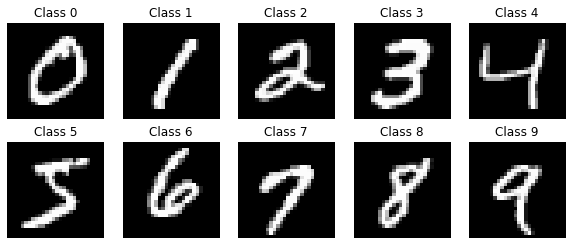

In [30]:
net.show_instances()

histogram for dataset:

it distributed well and does not need normalization

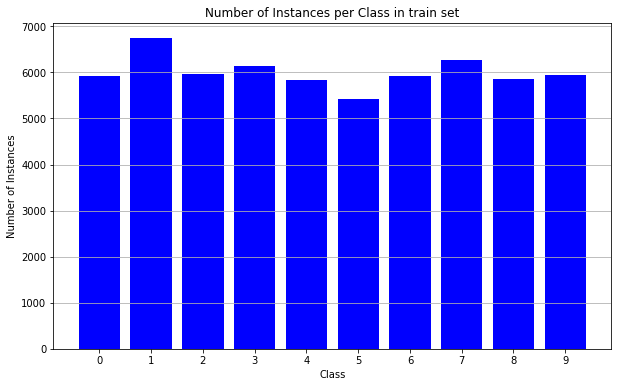

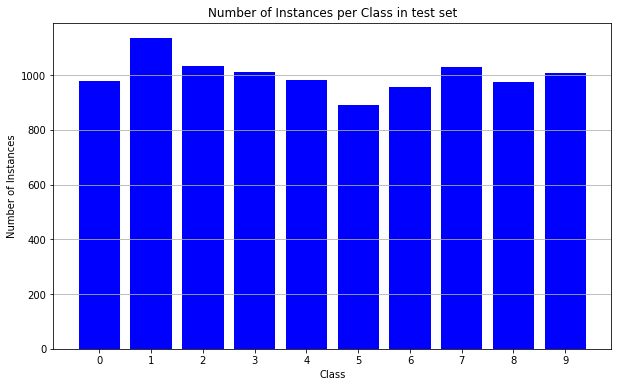

In [33]:
net.report_dataset_distribution()

scaling with min max normalization: scaling pixel values to the range [0, 1] is a crucial preprocessing step that aids in normalization, improves training efficiency, ensures consistency with activation functions, maintains numerical stability, and supports uniform learning dynamics.

Report encoder/decoder and test and train loss

28 pixel * 28 pixel = 784 (flatten the data)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 30)                445630    
                                                                 
 decoder (Functional)        (None, 784)               446384    
                                                                 
Total params: 892014 (3.40 MB)
Trainable params: 892014 (3.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


C:\Users\ASC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
235/235 [==============================] - 29s 26ms/step - loss: 0.0566 - val_loss: 0.0324
Epoch 2/50
235/235 [==============================] - 6s 24ms/step - loss: 0.0244 - val_loss: 0.0192
Epoch 3/50
235/235 [==============================] - 6s 25ms/step - loss: 0.0176 - val_loss: 0.0154
Epoch 4/50
235/235 [==============================] - 6s 24ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 5/50
235/235 [==============================] - 6s 24ms/step - loss: 0.0129 - val_loss: 0.0120
Epoch 6/50
235/235 [==============================] - 6s 24ms/step - loss: 0.0117 - val_loss: 0.0110
Epoch 7/50
235/235 [==============================] - 6s 24ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 8/50
235/235 [==============================] - 6s 23ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 9/50
235/235 [==============================] - 6s 24ms/step - loss: 0.0098 - val_loss: 0.0095
Epoch 10/50
235/235 [==============================] - 6s 24ms/step - loss: 0.0093 - val_l

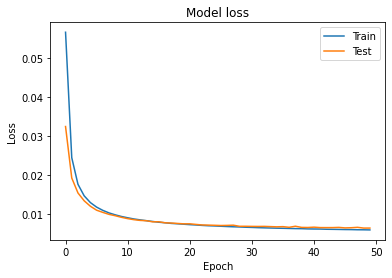

In [54]:
net.normalize_dataset()
net.encoder_decoder()

classify using output of encoder

accuracy: 97.5%

output the train and validation's accuracy and loss

the softmax function is essential for producing a valid probability distribution over output classes, and ensuring that the model's predictions are interpretable and useful for downstream tasks.

Epoch 1/50

235/235 [==============================] - 4s 5ms/step - loss: 0.8081 - accuracy: 0.7593 - val_loss: 0.3126 - val_accuracy: 0.9075
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.2795 - accuracy: 0.9155 - val_loss: 0.2544 - val_accuracy: 0.9185
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.2254 - accuracy: 0.9315 - val_loss: 0.1912 - val_accuracy: 0.9420
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1947 - accuracy: 0.9407 - val_loss: 0.1795 - val_accuracy: 0.9440
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1756 - accuracy: 0.9463 - val_loss: 0.1547 - val_accuracy: 0.9535
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1610 - accuracy: 0.9505 - val_loss: 0.1441 - val_accuracy: 0.9556
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1471 - accuracy: 0.9550 - val_loss: 0.1449 - val_accuracy: 0.9531
Epoch

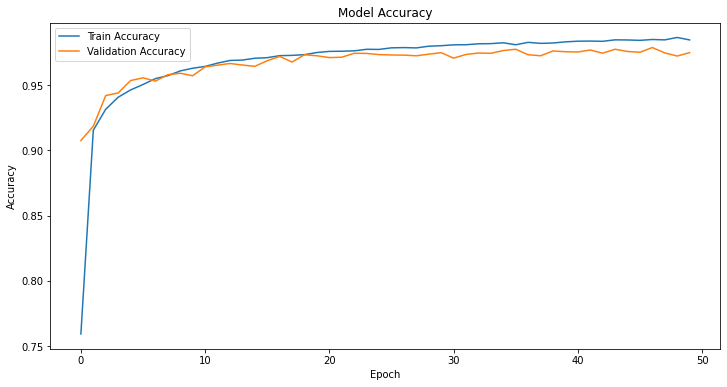

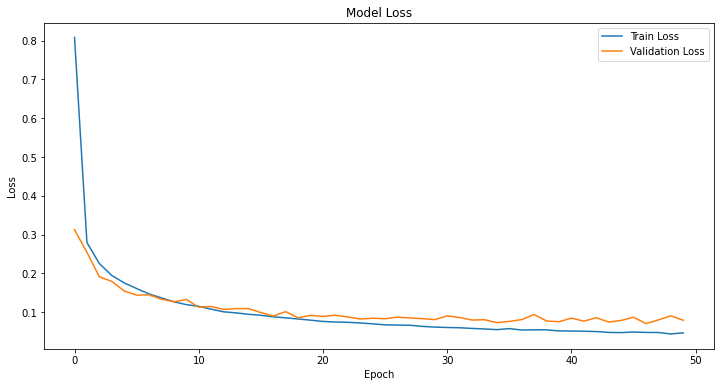

313/313 [==============================] - 1s 2ms/step


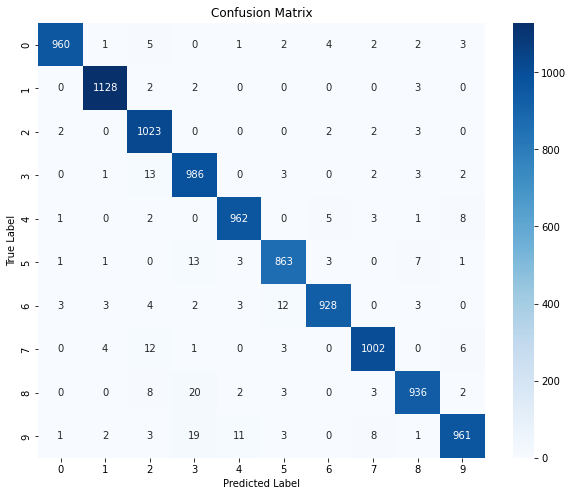

In [55]:
net.classifier()